In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms
import plotter as pltr
from copy import copy
pltr.set_backend(pltr.MatplotlibBackend)

In [2]:
# Utility function to plot images
white = pltr.Color(red=255, green=255, blue=255)
big_white_font = pltr.Font(color=white, size=14)
    
def rehydrate(img):
    img = copy(img.numpy())
    img = img.squeeze()  # Get rid of the single channel dim
    img = (img * 0.5) + 0.5  # Denormalize
    img = 255 * img  # Re-scale to 0-255
    return img
    
def show_imgs(imgs, titles):
    frame = pltr.Frame()
    frame.layout(1, len(imgs))  # Show all the images in a single row
    for img, title in zip(imgs, titles):
        chart = frame.create_chart()
        chart.title = title
        chart.title_font = big_white_font
        chart.show_axes = False
        imgplot = pltr.GrayscaleImage(img)
        chart.add(imgplot)
    frame.show()
    
def show_classification(img, label, probs):
    frame = pltr.Frame()
    frame.layout(1, 2)
    
    # Image chart
    chart = frame.create_chart()
    chart.title = label
    chart.title_font = big_white_font
    chart.show_axes = False
    imgplot = pltr.GrayscaleImage(img)
    chart.add(imgplot)
    
    # Probs plot
    chart = frame.create_chart()
    chart.title = 'Class Probabilities'
    chart.title_font = big_white_font
    chart.x_axis.limits = (0, 1)
    chart.x_axis.font = pltr.Font(color=white)
    chart.y_axis.font = pltr.Font(color=white)
    cats = [str(v) for v in range(len(probs))]
    probsplot = pltr.HorizontalBar(categories=cats, values=probs)
    chart.add(probsplot)
    
    frame.show()

In [3]:
# These are grayscale images so we only need to normalize the single channel
xforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
trainset = datasets.MNIST('/data/pytorch/mnist/', download=True, train=True, transform=xforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('/data/pytorch/mnist/', download=True, train=False, transform=xforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
# Both images and labels are of type Tensor
# Batch of 64 instances. Images are 1x28x28.
# Based on our transforms, each image was first scaled to be between 0 and 1 and then normalized
# to have 0.5 and 0.5 stddev
images, labels = next(iter(trainloader))
print(type(images), type(labels))
ndx = 0
image = images[0]
label = labels[0]
print(image.size(), label.size())

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 28, 28]) torch.Size([])


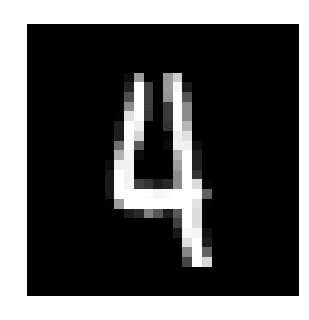

In [5]:
img = rehydrate(image)
show_imgs([img], [label.item()])

In [4]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=0)
        return x
    
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
# Weights are automatically initialized
print(model.fc1.weight.size())
print(model.fc1.bias.size())

torch.Size([128, 784])
torch.Size([128])


In [ ]:
# But I like setting my biases to zero
# Note how I am using .data.fill here because fc1.bias is an autograd variable and as such we
# cannot mutate its value directly
model.fc1.bias.data.fill_(0)

In [ ]:
images, labels = next(iter(trainloader))

# Flatten the 2D image into a single vector, but keep the channel dim, do not squeeze it out
images.resize_(64, 784)

ndx = 0
ps = model.forward(images[0])
img = rehydrate(images[0].view(28, 28))
probs = ps.detach().numpy().squeeze()
show_classification(img, labels[0].item(), probs)

Because all we are doing in the Network class is pass a tensor sequentially through, PyTorch provides an easier way to define such networks.

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(dim=0)
)
print(model)

In [ ]:
images, labels = next(iter(trainloader))
images.resize_(64, 784)
probs = model.forward(images[0]).detach().numpy().squeeze()
img = rehydrate(images[0].view(28, 28))
lbl = labels[0].item()
show_classification(img, lbl, probs)

In [6]:
from collections import OrderedDict

In [7]:
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(784, 128)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(128, 64)),
    ('relu2', nn.ReLU()),
    ('logits', nn.Linear(64, 10))
]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
model.fc1

Linear(in_features=784, out_features=128, bias=True)

In [ ]:
from torch import optim

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Single training epoch

In [ ]:
init_wts = copy(model.fc1.weight[:3, :3].detach().numpy())
print('Initial weights - ', init_wts)
images, labels = next(iter(trainloader))
images.resize_(64, 784)
optimizer.zero_grad()
output = model.forward(images)
loss = loss_fn(output, labels)
loss.backward()
grads = copy(model.fc1.weight.grad[:3, :3].detach().numpy())
print('Gradient - ', grads)

# This does the actual weight update
# If z is the output (or the leaf) variable in the compute graph
# and x is one of the roots, then doing a z.backward will calculate
# all the derivates of dz/d* for all of z's ancestors but we cannot access the intermediate grads
# x.grad will give us dz/dx, i.e., the gradient of x
# In the loss function, the parameters are the roots, so parameters.grad will give us dL/dW
# Optimizers use this grad state to update the parameters in the usual way: W := W - α(dL/dW)
optimizer.step()

# Now we should be able to see the new weights
print('Updated weights - ', model.fc1.weight[:3, :3])
exp_wts = init_wts - 0.01 * grads
print('Expected weights - ', exp_wts)

Full training

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.03)
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    tot_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Getting batch size from batch
        # instead of using 64 because the last batch might be smaller than 64
        images.resize_(images.size()[0], 784) 
        
        # Ensure that the param grads are zero'ed out otherwise they'll be accumulated
        # with every train step
        optimizer.zero_grad()  
        output = model.forward(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        tot_loss += loss.item()
        if steps % print_every == 0:
            avg_loss = tot_loss / print_every
            print(f'Epoch: {e}/{epochs}\tLoss: {avg_loss:.3f}')
            tot_loss = 0

In [ ]:
images, labels = next(iter(testloader))
image = images[0].view(1, 784)  # Create a "batch" of one
with torch.no_grad():
    logits = model.forward(image)
print(logits.size())
probs = F.softmax(logits, dim=1).detach().numpy().squeeze()
img = rehydrate(image.reshape(28, 28))
show_classification(img, labels[0].item(), probs)

In [ ]:
images, labels = next(iter(testloader))
batch_size = images.size()[0]
images = images.resize_(batch_size, 784)

In [ ]:
wrong_preds = []
tot_test_size = 0
with torch.no_grad():
    for images, labels in testloader:
        batch_size = images.size()[0]
        tot_test_size += batch_size
        images.resize_(batch_size, 784)
        logits = model.forward(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        for image, label, pred in zip(images, labels, preds):
            if label != pred:
                wrong_preds.append((image, label, pred))
acc = (tot_test_size - len(wrong_preds)) / tot_test_size
print(f'Accuracy: {acc:.3f}\tMisclassifications: {len(wrong_preds)}')

In [ ]:
import random

In [ ]:
wrong_preds_sample = random.sample(wrong_preds, k=5)
for image, label, pred in wrong_preds_sample:
    img = rehydrate(image.view(28, 28))
    title = f'Actual: {label}, Predicted {pred}'
    show_imgs([img], [title])
